In [54]:
from scripts.readers import read_images, read_image, save_TIFF

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import porespy as ps
import importlib as il
import os
import itertools

from scipy.stats import wilcoxon, ks_2samp, f_oneway, friedmanchisquare, levene
from skimage.io import imread # read in images
from skimage.measure import regionprops, regionprops_table
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from collections import OrderedDict
from importlib.metadata import version
from mpl_toolkits.mplot3d import Axes3D
from statistics import median

In [2]:
pores_pore_regionprops = il.import_module("pores.pore_regionprops")
pores_pore_metric_test = il.import_module("pores.pore_metric_test")

plots_plots_3d = il.import_module("plots.plots_3d")
plots_colormaps_lec = il.import_module("plots.colormaps_lec")

In [3]:
pores_pore_regionprops = il.reload(pores_pore_regionprops)
pores_pore_metric_test = il.reload(pores_pore_metric_test)

plots_plots_3d = il.reload(plots_plots_3d)
plots_colormaps_lec = il.reload(plots_colormaps_lec)

In [4]:
load_single = False # If true, will only load single bread type (good for visualisation of a single sample, not for analysis)

In [5]:
vx_size = 60.9e-6 # Voxel size in metres

if load_single:
    start_idx = 180
    end_idx = 829
    bread_type = 'V1a'
    #save_slice_num = str(int(end_idx-start_idx+1))
    # FIX: automatic slicenum detection
    if bread_type == 'Ro1a':
        save_slice_num = "650"
    elif bread_type == 'Ru1a':
        save_slice_num = "555"
    elif bread_type == 'V1a':
        save_slice_num = "650"
    elif bread_type == 'W1a':
        save_slice_num = "600"
    else:
        print('Check Bread Type')
    output_path = '/cluster/scratch/spruthi/qbi2024_project/'+bread_type+'_save_'+save_slice_num
    if os.path.exists(output_path):
        print('Starting')
    else:
        print('Target path created, check '+output_path)
        os.makedirs(output_path, exist_ok=True)
        print('You may want to manually specify save_slice_num')

In [6]:
if load_single:
    # Load stored images

    # Bread structure (pores = 0)
    connthresh_medfilter3_ds_img_1 = read_images(os.path.join(output_path, (bread_type+'_connthresh_medfilter3_ds_img_1_{0:04}.tif')), start_idx, end_idx)
    print(connthresh_medfilter3_ds_img_1.shape)

    # Filled bread (solid structure)
    filled_pores_1 = read_images(os.path.join(output_path, (bread_type+'_filled_pores_1_{0:04}.tif')), start_idx, end_idx)

    # Pores segmented based on connected components labelling
    merged_labelled_image_lbl = read_images(os.path.join(output_path, (bread_type+'_merged_labelled_image_lbl_{0:04}.tif')), start_idx, end_idx)

    # Pores segmented based on watershed analysis
    merged_labelled_image_ws = read_images(os.path.join(output_path, (bread_type+'_merged_labelled_image_ws_{0:04}.tif')), start_idx, end_idx)

    # Local thicnkess map of pores generated using porespy
    lt_ws = read_images(os.path.join(output_path, (bread_type+'_lt_ws_{0:04}.tif')), start_idx, end_idx)

In [10]:
# Load stored metrics
# Bread label => Ro1a = 1, Ru1a = 2, V1a = 3, W1a = 4
sphericity_pore = getattr(pores_pore_regionprops, "sphericity_pore") # Adding sphericity to dfs which don't have the metric

if load_single:
    df_pair_pore = pd.read_pickle(os.path.join(output_path, (bread_type+'_df_pair_pore.pkl')))
    df_pair_pore["sphericity"] = df_pair_pore.apply(lambda row: sphericity_pore(row["volume_ps"], row["surface_area"]), axis=1)
    df_pair_pore = pd.concat([df_pair_pore,pd.read_pickle(os.path.join(output_path, (bread_type+'_df_pair_pore2.pkl')))], ignore_index=True)
else:
    # FIX: automatic index detection
    start_indices = [150, 299, 180, 300]
    end_indices = [799, 853, 829, 899]
    bread_metrics_dict = {}
    bread_types = ["Ro1a", "Ru1a", "V1a", "W1a"]
    for i, bread in enumerate(bread_types):
        start_idx = start_indices[i]
        end_idx = end_indices[i]
        save_slice_num = str(int(end_idx-start_idx+1))
        output_path = '/cluster/scratch/spruthi/qbi2024_project/'+bread+'_save_'+save_slice_num
        bread_metrics_dict[bread] = pd.read_pickle(os.path.join(output_path, (bread+'_df_pair_pore.pkl')))
        bread_metrics_dict[bread]["sphericity"] = bread_metrics_dict[bread].apply(lambda row: sphericity_pore(row["volume_ps"], row["surface_area"]), axis=1)
        bread_metrics_dict[bread] = pd.concat([bread_metrics_dict[bread], pd.read_pickle(os.path.join(output_path, (bread+'_df_pair_pore2.pkl')))], ignore_index=True)

In [11]:
bread_metrics_dict["W1a"].shape

(23909, 11)

In [106]:
bread_metrics_dict["Ro1a"].sample(5)

,label,centroid-0,centroid-1,centroid-2,volume_ps,surface_area,length,distance_centroid,distance_centroid_zconstraint,bread_label,sphericity
23,24,0.666667,939.916667,393.041667,24,40.931847,4,325.828861,31.182297,1,0.983023
536,537,82.900000,533.800000,490.650000,20,43.392548,6,482.876818,417.800924,1,0.821150
8326,8327,544.897436,1068.961538,693.032051,156,247.011902,11,419.702172,357.484309,1,0.567348
14153,4867,485.913146,612.084507,362.852113,426,418.016174,13,512.232748,486.301704,1,0.654984
9611,325,139.269805,414.215844,677.110218,1742,1055.990112,22,305.209948,242.192912,1,0.663015


In [12]:
# Filtering by pore volume (<1e6 and >25)
greater_than = 50
less_than = 2e6

for bread in bread_types:
    bread_metrics_dict[bread] = bread_metrics_dict[bread][(bread_metrics_dict[bread]["volume_ps"]<less_than) & (bread_metrics_dict[bread]["volume_ps"]>greater_than)]
bread_metrics_dict["W1a"].shape

(15878, 11)

In [96]:
# Filtering by position of centroid-0 by median
bread_metrics_dict_centroid = {}
bread_metrics_dict_centroid_diff = {}
bread_metrics_dict_centroid_large = {}
bread_metrics_dict_large = {}
bread_metrics_dict_centroid_large_diff = {}
large_pore_size = 15000

for bread in bread_types:
    bread_metrics_dict_centroid[bread] = bread_metrics_dict[bread][bread_metrics_dict[bread]["centroid-0"]<median(bread_metrics_dict[bread]["centroid-0"])]
    bread_metrics_dict_centroid_diff[bread] = bread_metrics_dict[bread][bread_metrics_dict[bread]["centroid-0"]>median(bread_metrics_dict[bread]["centroid-0"])]
    print(f'Number of large (>{large_pore_size}) pores after z-filtering for bread {bread} (%) = {(bread_metrics_dict_centroid[bread][bread_metrics_dict_centroid[bread]["volume_ps"]>large_pore_size].shape[0]/bread_metrics_dict[bread][bread_metrics_dict[bread]["volume_ps"]>large_pore_size].shape[0])*100}%')
    
    bread_metrics_dict_centroid_large[bread] = bread_metrics_dict_centroid[bread][(bread_metrics_dict_centroid[bread]["volume_ps"]>large_pore_size)]
    bread_metrics_dict_centroid_large_diff[bread] = bread_metrics_dict_centroid_diff[bread][(bread_metrics_dict_centroid_diff[bread]["volume_ps"]>large_pore_size)]
    bread_metrics_dict_large[bread] = bread_metrics_dict[bread][(bread_metrics_dict[bread]["volume_ps"]>large_pore_size)]

Number of large (>15000) pores after z-filtering for bread Ro1a (%) = 69.8051948051948%
Number of large (>15000) pores after z-filtering for bread Ru1a (%) = 66.75461741424802%
Number of large (>15000) pores after z-filtering for bread V1a (%) = 73.4126984126984%
Number of large (>15000) pores after z-filtering for bread W1a (%) = 63.984674329501914%


In [96]:
# (Extreme) Filtering by pore volume (>1000)
extreme_greater_than = 10000

for bread in bread_types:
    bread_metrics_dict[bread] = bread_metrics_dict[bread][(bread_metrics_dict[bread]["volume_ps"]>extreme_greater_than)]

In [57]:
normalize_metrics = ['label','centroid-0','centroid-1','centroid-2','volume_ps','sphericity', 'surface_area', 'distance_centroid']

for j, normal in enumerate(normalize_metrics):
    metric = str('n'+normal)
    for i, bread in enumerate(bread_types):
        bread_metrics_dict[bread][metric] = (bread_metrics_dict[bread][normal]-bread_metrics_dict[bread][normal].mean())/bread_metrics_dict[bread][normal].std()

In [ ]:
bread_metrics_dict["Ro1a"]

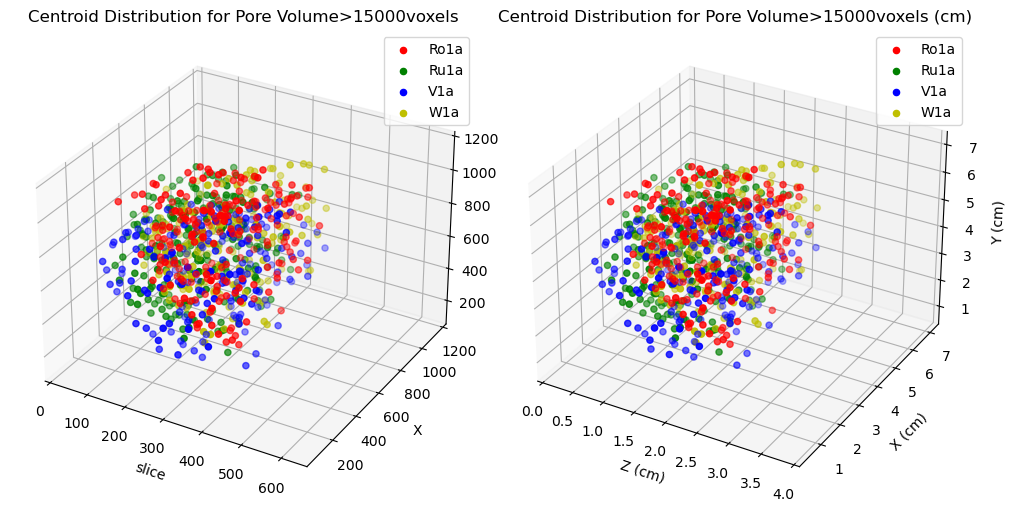

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), subplot_kw={'projection': '3d'})

# Define colors for each dataframe
colors = ['r', 'g', 'b', 'y']

# Plot centroids from each dataframe
for i, (label, df) in enumerate(bread_metrics_dict_centroid_large.items()):
    ax[0].scatter(df['centroid-0'], df['centroid-1'], df['centroid-2'], c=colors[i], label=label)
    # Convert centroids to centimeters and plot in the second subplot
    ax[1].scatter(df['centroid-0'] * vx_size * 100, df['centroid-1'] * vx_size * 100, df['centroid-2'] * vx_size * 100, c=colors[i], label=label)

# Set labels and legend for the first subplot
ax[0].set_xlabel('slice')
ax[0].set_ylabel('X')
ax[0].set_zlabel('Y')
ax[0].set_xlim((0,650))
#ax[0].set_title(f'Centroid Distribution for Pore Volume>{greater_than}voxels')
ax[0].set_title(f'Centroid Distribution for Pore Volume>{large_pore_size}voxels')
ax[0].legend()

# Set labels and legend for the second subplot
ax[1].set_xlabel('Z (cm)')
ax[1].set_ylabel('X (cm)')
ax[1].set_zlabel('Y (cm)')
ax[1].set_xlim((0,4))
#ax[1].set_title(f'Centroid Distribution for Pore Volume>{greater_than}voxels (cm)')
ax[1].set_title(f'Centroid Distribution for Pore Volume>{large_pore_size}voxels (cm)')
ax[1].legend()

# Show plot
plt.tight_layout()
plt.show()

In [92]:
bread_metrics_dict_centroid_large_diff = {}
for bread in bread_types:
    bread_metrics_dict_centroid_large_diff[bread] = pd.concat([bread_metrics_dict_large[bread],bread_metrics_dict_centroid_large[bread]]).drop_duplicates(keep=False)

In [102]:
bread_metrics_dict_centroid_large["Ro1a"]

,label,centroid-0,centroid-1,centroid-2,volume_ps,surface_area,length,distance_centroid,distance_centroid_zconstraint,bread_label,sphericity,nlabel,ncentroid-0,ncentroid-1,ncentroid-2,nvolume_ps,nsphericity,nsurface_area,ndistance_centroid
7,8,6.156577,866.964501,372.948941,15296,3063.258301,47,325.484988,65.416734,1,0.972790,-1.456183,-2.335333,0.873226,-1.197400,-0.318087,2.307804,-0.470895,-0.146156
12,13,14.858385,909.985723,298.570615,36352,12341.702148,81,317.497795,67.948720,1,0.429993,-1.451644,-2.245186,1.056062,-1.513627,-0.230273,-1.671662,-0.057840,-0.213053
125,126,39.830630,890.375773,444.302418,30891,10493.510742,99,299.391319,91.178904,1,0.453717,-1.349074,-1.986485,0.972722,-0.894033,-0.253048,-1.497734,-0.140118,-0.364705
164,165,101.967036,716.345508,346.466416,649776,96278.257812,248,310.416963,215.905045,1,0.376818,-1.313673,-1.342779,0.233111,-1.309993,2.328000,-2.061508,3.678819,-0.272359
196,197,48.214825,881.744902,335.337597,19467,6277.138672,56,282.598056,57.023051,1,0.557513,-1.284627,-1.899628,0.936041,-1.357308,-0.300692,-0.736759,-0.327821,-0.505357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11925,2639,368.851739,169.808187,643.633154,20619,5169.136719,47,465.394169,463.323599,1,0.703468,0.931989,1.422026,-2.089614,-0.046558,-0.295887,0.333297,-0.377146,1.025659
11942,2656,375.321452,367.621753,1092.954201,51202,9302.291016,62,331.304649,327.460718,1,0.716834,0.947420,1.489049,-1.248927,1.863776,-0.168341,0.431290,-0.193148,-0.097413
12001,2715,369.711243,837.646074,508.345085,17984,4709.494141,44,425.759556,423.405366,1,0.704857,1.000975,1.430930,0.748626,-0.621749,-0.306876,0.343475,-0.397608,0.693698
12061,2775,374.580636,602.865108,963.610744,17703,4468.762695,42,126.614093,116.502743,1,0.735069,1.055437,1.481375,-0.249168,1.313859,-0.308048,0.564975,-0.408325,-1.811807


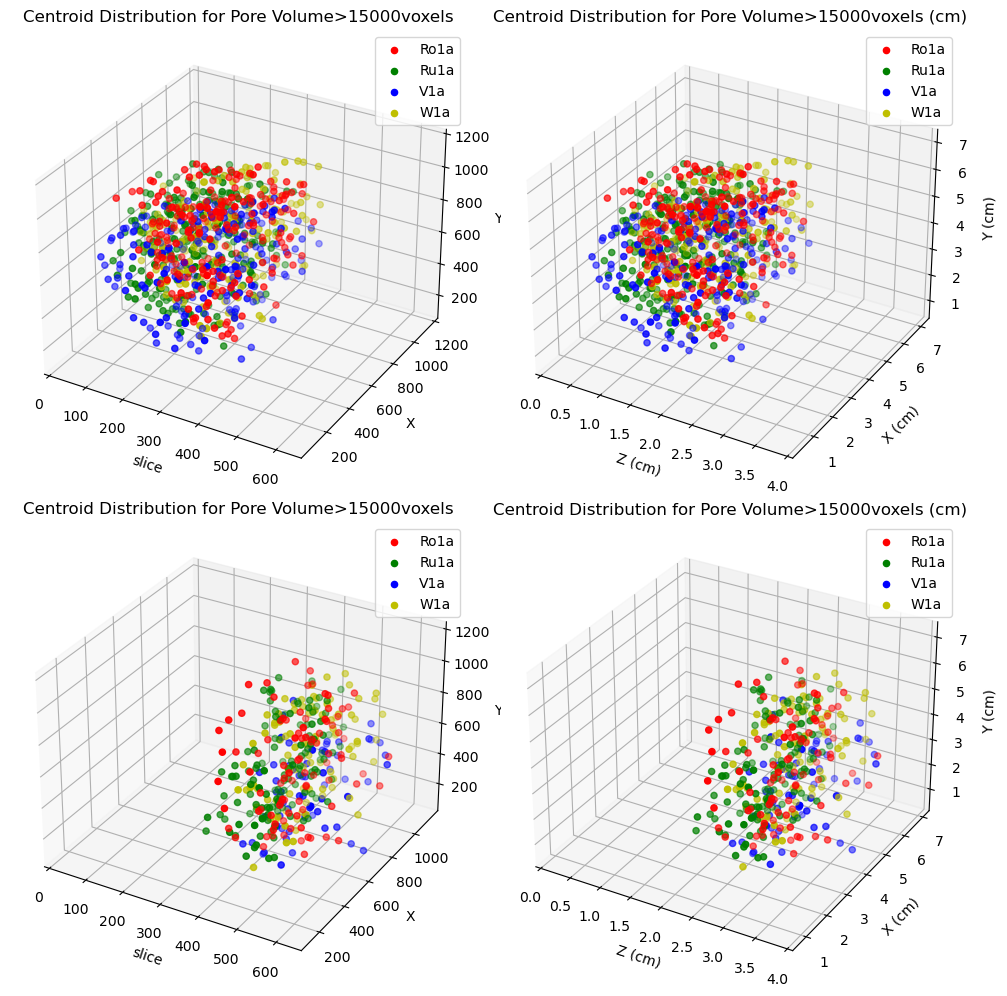

In [103]:
fig, ax = plt.subplots(2, 2, figsize=(10,10), subplot_kw={'projection': '3d'})

# Define colors for each dataframe
colors = ['r', 'g', 'b', 'y']

# Plot centroids from each dataframe
for i, (label, df) in enumerate(bread_metrics_dict_centroid_large.items()):
    ax[0,0].scatter(df['centroid-0'], df['centroid-1'], df['centroid-2'], c=colors[i], label=label)
    # Convert centroids to centimeters and plot in the second subplot
    ax[0,1].scatter(df['centroid-0'] * vx_size * 100, df['centroid-1'] * vx_size * 100, df['centroid-2'] * vx_size * 100, c=colors[i], label=label)

# Set labels and legend for the first subplot
ax[0,0].set_xlabel('slice')
ax[0,0].set_ylabel('X')
ax[0,0].set_zlabel('Y')
ax[0,0].set_xlim((0,650))
ax[0,0].set_title(f'Centroid Distribution for Pore Volume>{large_pore_size}voxels')
ax[0,0].legend()

# Set labels and legend for the second subplot
ax[0,1].set_xlabel('Z (cm)')
ax[0,1].set_ylabel('X (cm)')
ax[0,1].set_zlabel('Y (cm)')
ax[0,1].set_xlim((0,4))
ax[0,1].set_title(f'Centroid Distribution for Pore Volume>{large_pore_size}voxels (cm)')
ax[0,1].legend()

for i, (label, df) in enumerate(bread_metrics_dict_centroid_large_diff.items()):
    ax[1,0].scatter(df['centroid-0'], df['centroid-1'], df['centroid-2'], c=colors[i], label=label)
    # Convert centroids to centimeters and plot in the second subplot
    ax[1,1].scatter(df['centroid-0'] * vx_size * 100, df['centroid-1'] * vx_size * 100, df['centroid-2'] * vx_size * 100, c=colors[i], label=label)

# Set labels and legend for the first subplot
ax[1,0].set_xlabel('slice')
ax[1,0].set_ylabel('X')
ax[1,0].set_zlabel('Y')
ax[1,0].set_xlim((0,650))
ax[1,0].set_title(f'Centroid Distribution for Pore Volume>{large_pore_size}voxels')
ax[1,0].legend()

# Set labels and legend for the second subplot
ax[1,1].set_xlabel('Z (cm)')
ax[1,1].set_ylabel('X (cm)')
ax[1,1].set_zlabel('Y (cm)')
ax[1,1].set_xlim((0,4))
ax[1,1].set_title(f'Centroid Distribution for Pore Volume>{large_pore_size}voxels (cm)')
ax[1,1].legend()

# Show plot
plt.tight_layout()
plt.show()

In [39]:
bread_metrics_dict_centroid_large["Ro1a"].shape

(163, 11)

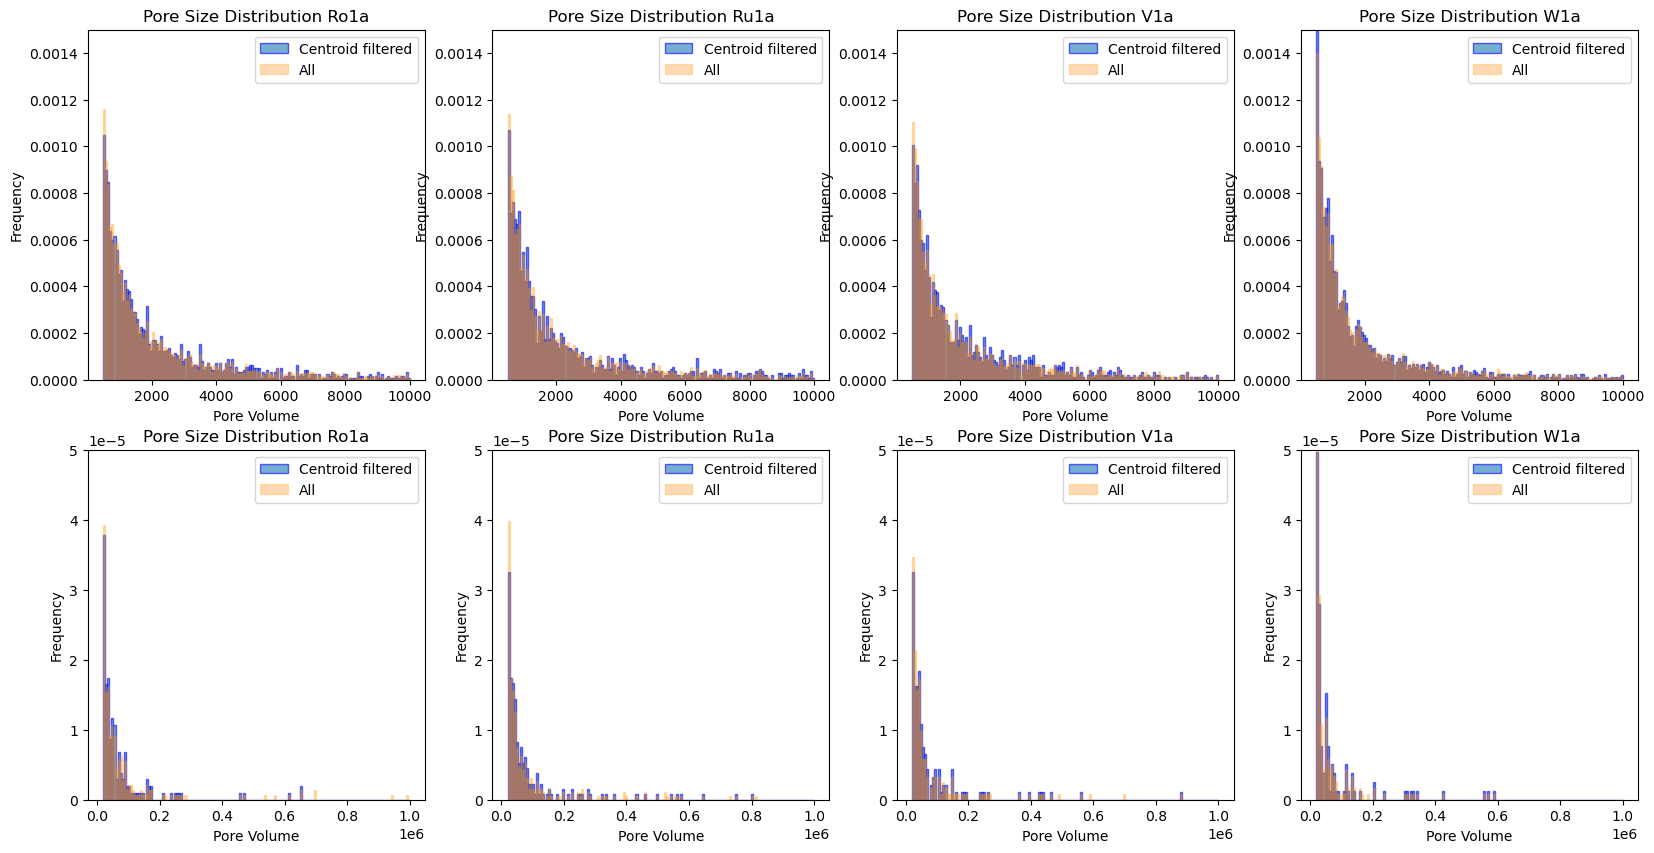

In [45]:
fig, ax = plt.subplots(2,4,figsize=(20,10))

for i,bread in enumerate(bread_types):
    # Plot the pore size distribution
    ax[0,i].hist(bread_metrics_dict_centroid[bread]["volume_ps"], bins=151, density=True, range=(500,10000), edgecolor='blue', alpha=0.6, label='Centroid filtered')
    ax[0,i].hist(bread_metrics_dict[bread]["volume_ps"], bins=151, density=True, range=(500,10000), edgecolor='orange', alpha=0.3, label='All')
    ax[0,i].set_xlabel('Pore Volume')
    ax[0,i].set_ylabel('Frequency')
    ax[0,i].set_title(f'Pore Size Distribution {bread}')
    ax[0,i].legend(loc='upper right')
    ax[0,i].set_ylim((0,0.0015))

for i,bread in enumerate(bread_types):
    # Plot the pore size distribution
    ax[1,i].hist(bread_metrics_dict_centroid_large[bread]["volume_ps"], bins=151, density=True, range=(20000,1e6), edgecolor='blue', alpha=0.6, label='Centroid filtered')
    ax[1,i].hist(bread_metrics_dict_large[bread]["volume_ps"], bins=151, density=True, range=(20000,1e6), edgecolor='orange', alpha=0.3, label='All')
    ax[1,i].set_xlabel('Pore Volume')
    ax[1,i].set_ylabel('Frequency')
    ax[1,i].set_title(f'Pore Size Distribution {bread}')
    ax[1,i].legend(loc='upper right')
    ax[1,i].set_ylim((0,5e-5))

# # Plot the pore length distribution
# ax[1].hist(pore_lengths_ws, bins=101, density=True, range=(0,75), edgecolor='blue', alpha=0.6, label='Watershed')
# ax[1].hist(pore_lengths_lbl, bins=101, density=True, range=(0,75), edgecolor='orange', alpha=0.3, label='Label')
# ax[1].set_xlabel('Pore Length')
# ax[1].set_ylabel('Frequency')
# ax[1].set_title('Pore Length Distribution')
# ax[1].legend(loc='upper right')

In [99]:
normalize_metrics = ['label','centroid-0','centroid-1','centroid-2','volume_ps','sphericity', 'surface_area', 'distance_centroid']

for j, normal in enumerate(normalize_metrics):
    metric = str('n'+normal)
    for i, bread in enumerate(bread_types):
        bread_metrics_dict_centroid_large[bread][metric] = (bread_metrics_dict_centroid_large[bread][normal]-bread_metrics_dict_centroid_large[bread][normal].mean())/bread_metrics_dict_centroid_large[bread][normal].std()

/scratch/tmp.60669332.spruthi/ipykernel_24937/2188321458.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bread_metrics_dict_centroid_large[bread][metric] = (bread_metrics_dict_centroid_large[bread][normal]-bread_metrics_dict_centroid_large[bread][normal].mean())/bread_metrics_dict_centroid_large[bread][normal].std()


In [100]:
bread_metrics_dict_centroid_large["Ru1a"].sample(5)

,label,centroid-0,centroid-1,centroid-2,volume_ps,surface_area,length,distance_centroid,distance_centroid_zconstraint,bread_label,sphericity,nlabel,ncentroid-0,ncentroid-1,ncentroid-2,nvolume_ps,nsphericity,nsurface_area,ndistance_centroid
3686,43,9.740157,830.434856,378.664825,23164,7809.345703,91,337.336522,205.184297,2,0.503205,-1.397538,-2.070737,0.836580,-0.966272,-0.372566,-1.259381,-0.311902,0.349656
5228,1585,177.852992,1077.187149,549.672303,73989,25673.451172,188,354.670746,340.384800,2,0.331980,0.518620,-0.093589,1.980688,-0.153813,-0.095854,-2.378123,0.729527,0.555536
4251,608,107.967685,560.207701,502.992509,76095,15028.978516,82,251.798060,186.174803,2,0.577819,-0.695444,-0.915499,-0.416374,-0.375590,-0.084388,-0.771873,0.108983,-0.666290
1344,1345,259.130474,408.969365,805.717252,15505,5191.264160,65,285.017546,284.424967,2,0.579240,0.220385,0.862302,-1.117616,1.062659,-0.414265,-0.762588,-0.464529,-0.271740
91,92,77.809136,528.388546,644.514619,35638,6797.083496,59,222.061599,97.133479,2,0.770496,-1.336648,-1.270189,-0.563909,0.296784,-0.304652,0.487024,-0.370914,-1.019473


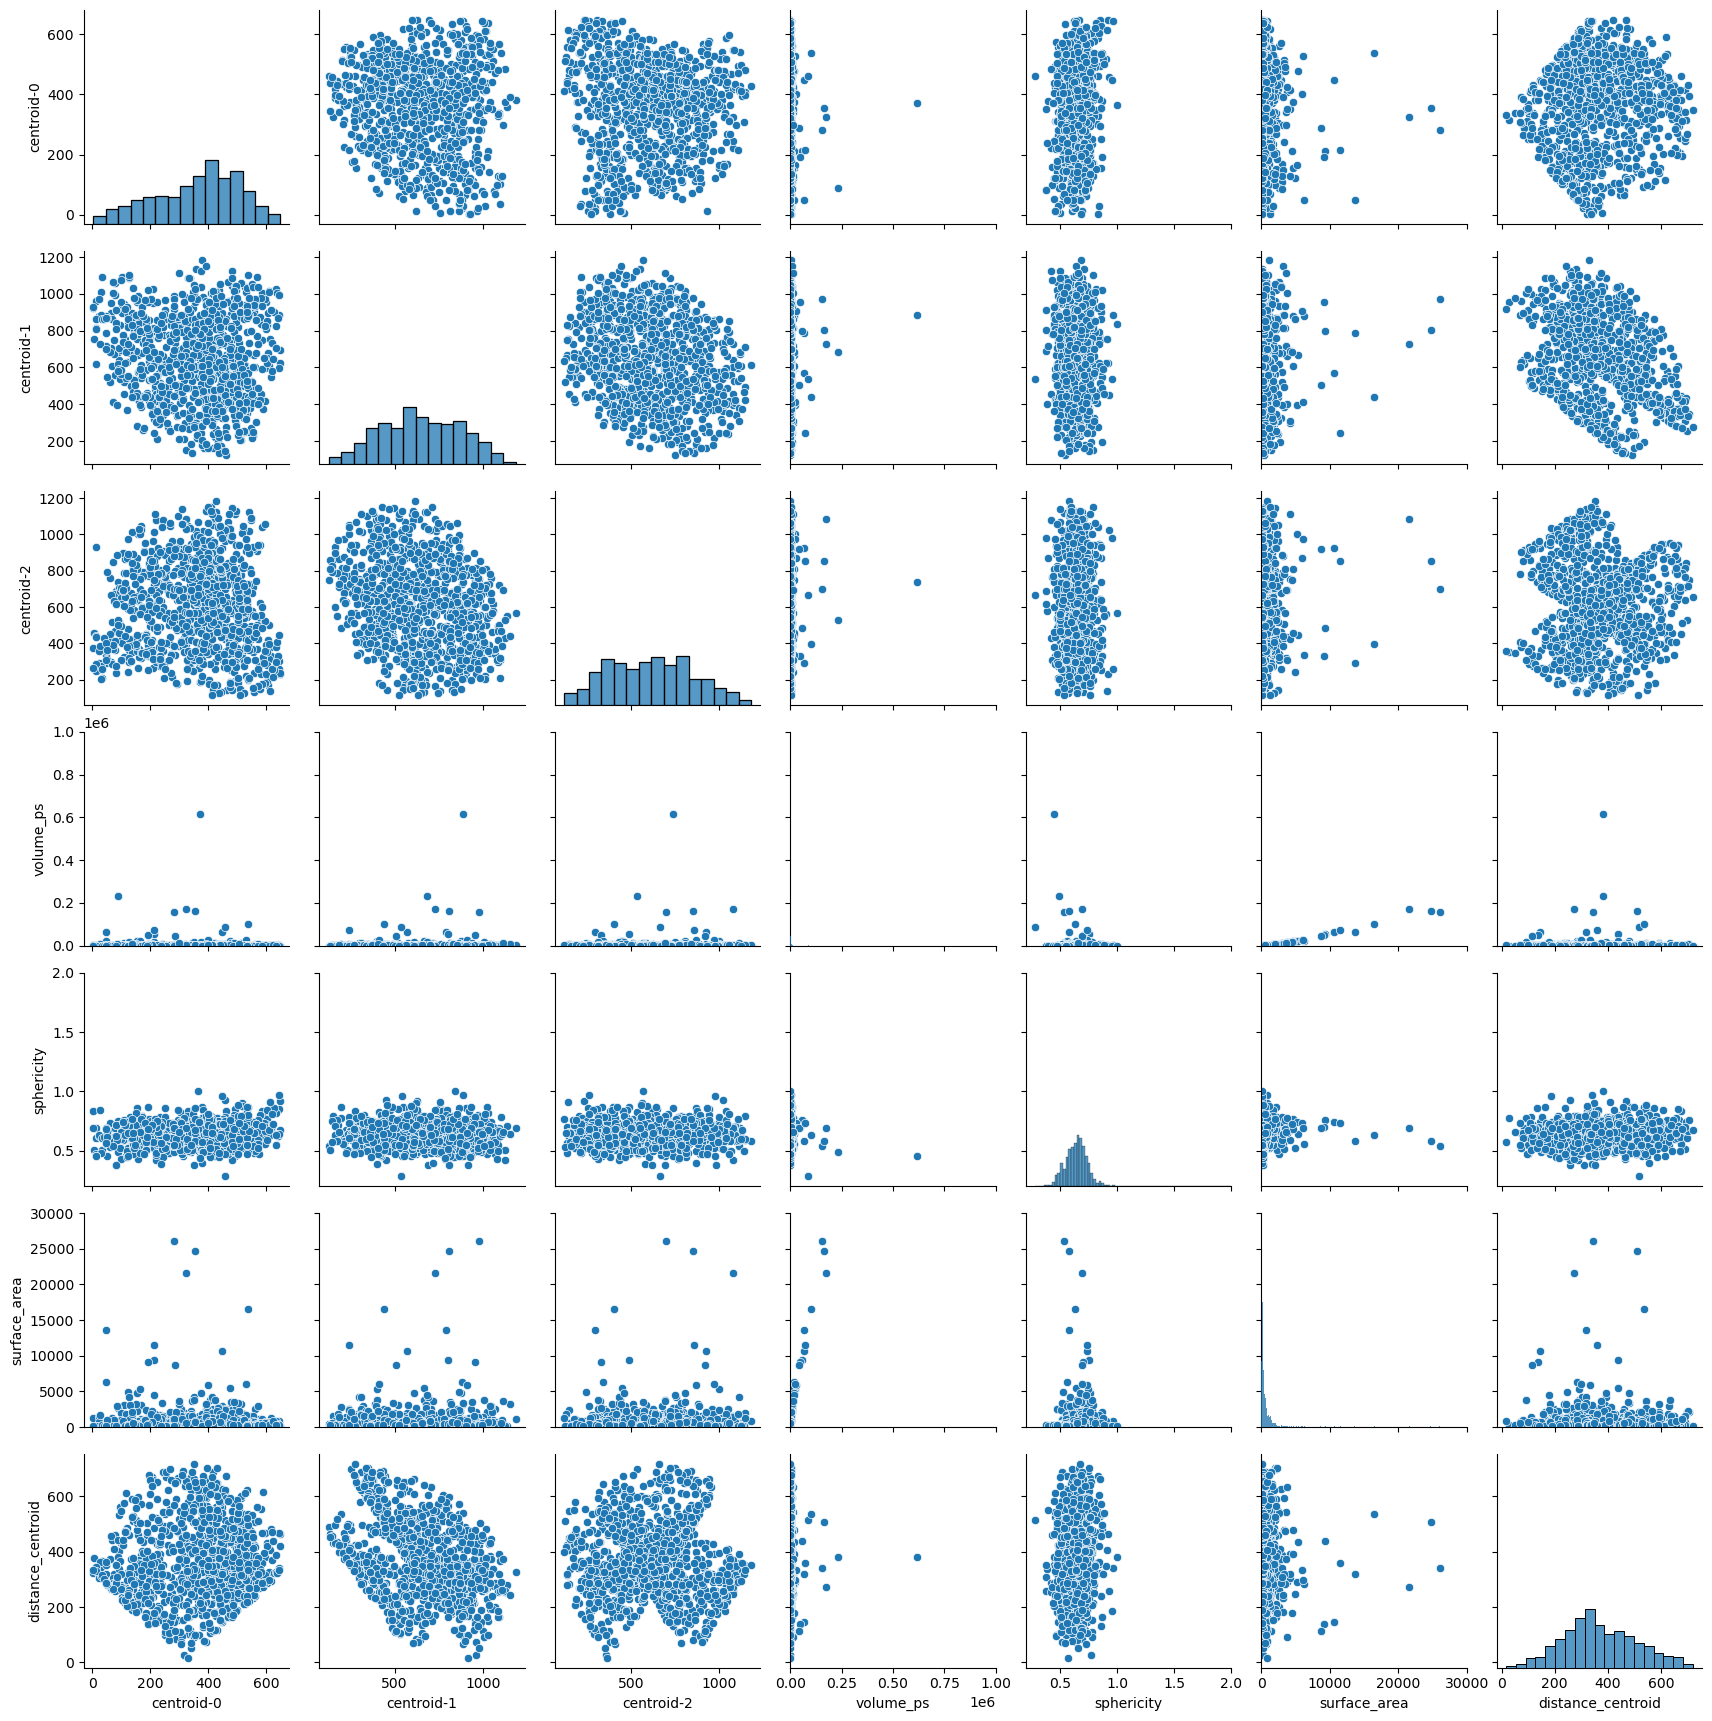

In [22]:
df_pairplot_pore = sns.pairplot(bread_metrics_dict["Ro1a"].sample(1000),vars=['centroid-0', 'centroid-1', 'centroid-2', 'volume_ps', 'sphericity', 'surface_area', 'distance_centroid']);

df_pairplot_pore.axes[0,3].set_xlim((0,1e6))
df_pairplot_pore.axes[0,4].set_xlim((0.2,2))
df_pairplot_pore.axes[0,5].set_xlim((0,3e4))

df_pairplot_pore.axes[3,0].set_ylim((0,1e6))
df_pairplot_pore.axes[4,0].set_ylim((0.2,2))
df_pairplot_pore.axes[5,0].set_ylim((0,3e4))

plt.show()
#plt.subplots_adjust(top=(0.95))
#plt.suptitle('Pairplot for Bread '+bread_type+' | Slices='+str(start_idx)+':'+str(end_idx), fontsize=20)

In [ ]:
df_pairplot_pore = sns.pairplot(bread_metrics_dict_centroid_large["Ro1a"].sample(200),vars=['ncentroid-0', 'ncentroid-1', 'ncentroid-2', 'nvolume_ps', 'nsphericity', 'nsurface_area', 'ndistance_centroid']);

df_pairplot_pore.axes[0,3].set_xlim((-0.1,25))
df_pairplot_pore.axes[0,4].set_xlim((0.2,2))
df_pairplot_pore.axes[0,5].set_xlim((-0.1,25))

df_pairplot_pore.axes[3,0].set_ylim((-0.1,25))
df_pairplot_pore.axes[4,0].set_ylim((0.2,2))
df_pairplot_pore.axes[5,0].set_ylim((-0.1,25))

plt.show()
#plt.subplots_adjust(top=(0.95))
#plt.suptitle('Pairplot for Bread '+bread_type+' | Slices='+str(start_idx)+':'+str(end_idx), fontsize=20)

In [105]:
test_df_pore = pd.concat([bread_metrics_dict["Ro1a"],bread_metrics_dict["Ru1a"],bread_metrics_dict["V1a"],bread_metrics_dict["W1a"]], ignore_index=True)
test_df_pore_centroid_large = pd.concat([bread_metrics_dict_centroid_large["Ro1a"],bread_metrics_dict_centroid_large["Ru1a"],bread_metrics_dict_centroid_large["V1a"],bread_metrics_dict_centroid_large["W1a"]], ignore_index=True)

In [17]:
test_df_pore_length = test_df_pore.shape[0]

In [108]:
kmeans= KMeans(4)
x=kmeans.fit_predict(test_df_pore_centroid_large[['centroid-0','centroid-1','centroid-2','volume_ps','sphericity']].values)
test_df_pore_centroid_large['group']=x.tolist()
test_df_pore_centroid_large.sample(5,random_state=30)

,label,centroid-0,centroid-1,centroid-2,volume_ps,surface_area,length,distance_centroid,distance_centroid_zconstraint,bread_label,sphericity,nlabel,ncentroid-0,ncentroid-1,ncentroid-2,nvolume_ps,nsphericity,nsurface_area,ndistance_centroid,group
724,3660,326.369336,731.699285,290.710408,73272,13661.533203,70,154.232860,151.961947,4,0.619836,0.923284,0.907332,0.205122,-1.554145,-0.106290,-0.143848,-0.073063,-1.350715,0
346,309,93.816157,507.176885,572.131542,323928,40614.957031,177,294.407809,230.078691,2,0.561604,-1.066994,-1.081933,-0.662260,-0.047109,1.264914,-0.877817,1.600577,-0.160211,2
55,2160,233.064663,957.613674,700.606033,17537,6457.112305,59,350.879667,338.621374,1,0.505533,0.497199,0.015333,1.258476,0.195668,-0.308741,-1.117848,-0.319809,0.066538,0
669,791,146.934108,422.097452,528.540843,33555,10251.150391,72,338.988733,302.463541,4,0.490776,-0.973860,-0.976857,-1.147268,-0.441281,-0.283629,-0.914917,-0.187693,0.122503,0
656,190,62.150802,764.873236,330.001675,47758,12036.772461,80,267.948687,123.386619,4,0.528857,-1.371275,-1.867138,0.350031,-1.370292,-0.220212,-0.687401,-0.127675,-0.443960,0


In [110]:
sum(test_df_pore_centroid_large["group"]!=0)

67

In [111]:
# Ro1a
for i in range(4):
    print(f'Group {i}: Ro1a={test_df_pore_centroid_large[(test_df_pore_centroid_large["group"]==i) & (test_df_pore_centroid_large["bread_label"]==1)].shape[0]}, Ru1a={test_df_pore_centroid_large[(test_df_pore_centroid_large["group"]==i) & (test_df_pore_centroid_large["bread_label"]==2)].shape[0]}, V1a={test_df_pore_centroid_large[(test_df_pore_centroid_large["group"]==i) & (test_df_pore_centroid_large["bread_label"]==3)].shape[0]}, W1a={test_df_pore_centroid_large[(test_df_pore_centroid_large["group"]==i) & (test_df_pore_centroid_large["bread_label"]==4)].shape[0]}')

Group 0: Ro1a=200, Ru1a=228, V1a=170, W1a=153
Group 1: Ro1a=3, Ru1a=5, V1a=2, W1a=4
Group 2: Ro1a=2, Ru1a=2, V1a=2, W1a=1
Group 3: Ro1a=10, Ru1a=18, V1a=11, W1a=9


In [112]:
kmeans= KMeans(4)
#x=kmeans.fit_predict(test_df_pore[['nlabel','ncentroid-0','ncentroid-1','ncentroid-2','nvolume_ps','nsphericity']].values)
x=kmeans.fit_predict(test_df_pore_centroid_large[['ncentroid-0','ncentroid-1','ncentroid-2','nvolume_ps','nsurface_area']].values)
test_df_pore_centroid_large['group']=x.tolist()
test_df_pore_centroid_large.sample(5,random_state=30)

,label,centroid-0,centroid-1,centroid-2,volume_ps,surface_area,length,distance_centroid,distance_centroid_zconstraint,bread_label,sphericity,nlabel,ncentroid-0,ncentroid-1,ncentroid-2,nvolume_ps,nsphericity,nsurface_area,ndistance_centroid,group
724,3660,326.369336,731.699285,290.710408,73272,13661.533203,70,154.232860,151.961947,4,0.619836,0.923284,0.907332,0.205122,-1.554145,-0.106290,-0.143848,-0.073063,-1.350715,0
346,309,93.816157,507.176885,572.131542,323928,40614.957031,177,294.407809,230.078691,2,0.561604,-1.066994,-1.081933,-0.662260,-0.047109,1.264914,-0.877817,1.600577,-0.160211,3
55,2160,233.064663,957.613674,700.606033,17537,6457.112305,59,350.879667,338.621374,1,0.505533,0.497199,0.015333,1.258476,0.195668,-0.308741,-1.117848,-0.319809,0.066538,0
669,791,146.934108,422.097452,528.540843,33555,10251.150391,72,338.988733,302.463541,4,0.490776,-0.973860,-0.976857,-1.147268,-0.441281,-0.283629,-0.914917,-0.187693,0.122503,0
656,190,62.150802,764.873236,330.001675,47758,12036.772461,80,267.948687,123.386619,4,0.528857,-1.371275,-1.867138,0.350031,-1.370292,-0.220212,-0.687401,-0.127675,-0.443960,0


In [80]:
# Ro1a
for i in range(4):
    print(f'Group {i}: Ro1a={test_df_pore[(test_df_pore["group"]==i) & (test_df_pore["bread_label"]==1)].shape[0]}, Ru1a={test_df_pore[(test_df_pore["group"]==i) & (test_df_pore["bread_label"]==2)].shape[0]}, V1a={test_df_pore[(test_df_pore["group"]==i) & (test_df_pore["bread_label"]==3)].shape[0]}, W1a={test_df_pore[(test_df_pore["group"]==i) & (test_df_pore["bread_label"]==4)].shape[0]}')

Group 0: Ro1a=4148, Ru1a=3269, V1a=2806, W1a=6019
Group 1: Ro1a=3193, Ru1a=2690, V1a=2297, W1a=4140
Group 2: Ro1a=4174, Ru1a=3070, V1a=2896, W1a=5710
Group 3: Ro1a=14, Ru1a=10, V1a=6, W1a=9


In [ ]:
# Plots - centroid of the breads (3D), 

In [ ]:
metrics_to_compare = ['centroid-0', 'volume_ps', 'sphericity']
sampling_size = 5000
for metric in metrics_to_compare:
    print(f'Comparing {metric} \n')
    for i,bread1 in enumerate(bread_types):
        for j,bread2 in enumerate(bread_types):
            if j>i:
                w_stat, p_value = wilcoxon(bread_metrics_dict[bread1][metric].sample(sampling_size), bread_metrics_dict[bread2][metric].sample(sampling_size))
                print(f"WS-Rank Test between {bread1} and {bread2}: W-statistic = {w_stat:.3f}, p-value = {p_value:.4e}")
                print(f'p-value after Bonferonni correction (*{sampling_size}): {p_value*sampling_size:.3e} (0.05)\n')

In [ ]:
metrics_to_compare = ['centroid-0', 'volume_ps', 'sphericity']
sampling_size = 5000
for m, metric in enumerate(metrics_to_compare):
    print(f'Comparing {metric} \n')
    for i,bread1 in enumerate(bread_types):
        for j,bread2 in enumerate(bread_types):
            if j>i:
                w_stat, p_value = ks_2samp(bread_metrics_dict[bread1][metric].sample(sampling_size), bread_metrics_dict[bread2][metric].sample(sampling_size))
                print(f"KS-Rank Test between {bread1} and {bread2}: KS-statistic = {w_stat:.3f}, p-value = {p_value:.4e}")
                print(f'p-value after Bonferonni correction (*{sampling_size}): {p_value*sampling_size:.3e} (0.05)\n')

In [49]:
# Pairwise Kolmogorov-Smirnov (KS) test to see if specified metric distributions between samples originate from different distributions
run_pairwise_ks_test = getattr(pores_pore_metric_test, "run_pairwise_ks_test")
create_metric_df = getattr(pores_pore_metric_test, "create_metric_df")

metrics_to_compare = ['centroid-0', 'centroid-2', 'volume_ps', 'surface_area', 'sphericity', 'distance_centroid', 'ncentroid-0', 'ncentroid-2', 'nvolume_ps', 'nsurface_area', 'nsphericity', 'ndistance_centroid']
sampling_size = 150
check = False

df_ks_p, ks_stats_list, p_values_list = run_pairwise_ks_test(bread_metrics_dict_centroid_large, metrics_to_compare, bread_types, sampling_size)

if check:
    print(len(df_ks_p))
    for i, (df_ks, df_p) in enumerate(df_ks_p):
        print(f"{metrics_to_compare[i]} KS Statistics:")
        print(df_ks)
        #print(f"{metrics_to_compare[i]} P-values:")
        #print(df_p)

['centroid-0', 'centroid-2', 'volume_ps', 'surface_area', 'sphericity', 'distance_centroid', 'ncentroid-0', 'ncentroid-2', 'nvolume_ps', 'nsurface_area', 'nsphericity', 'ndistance_centroid']


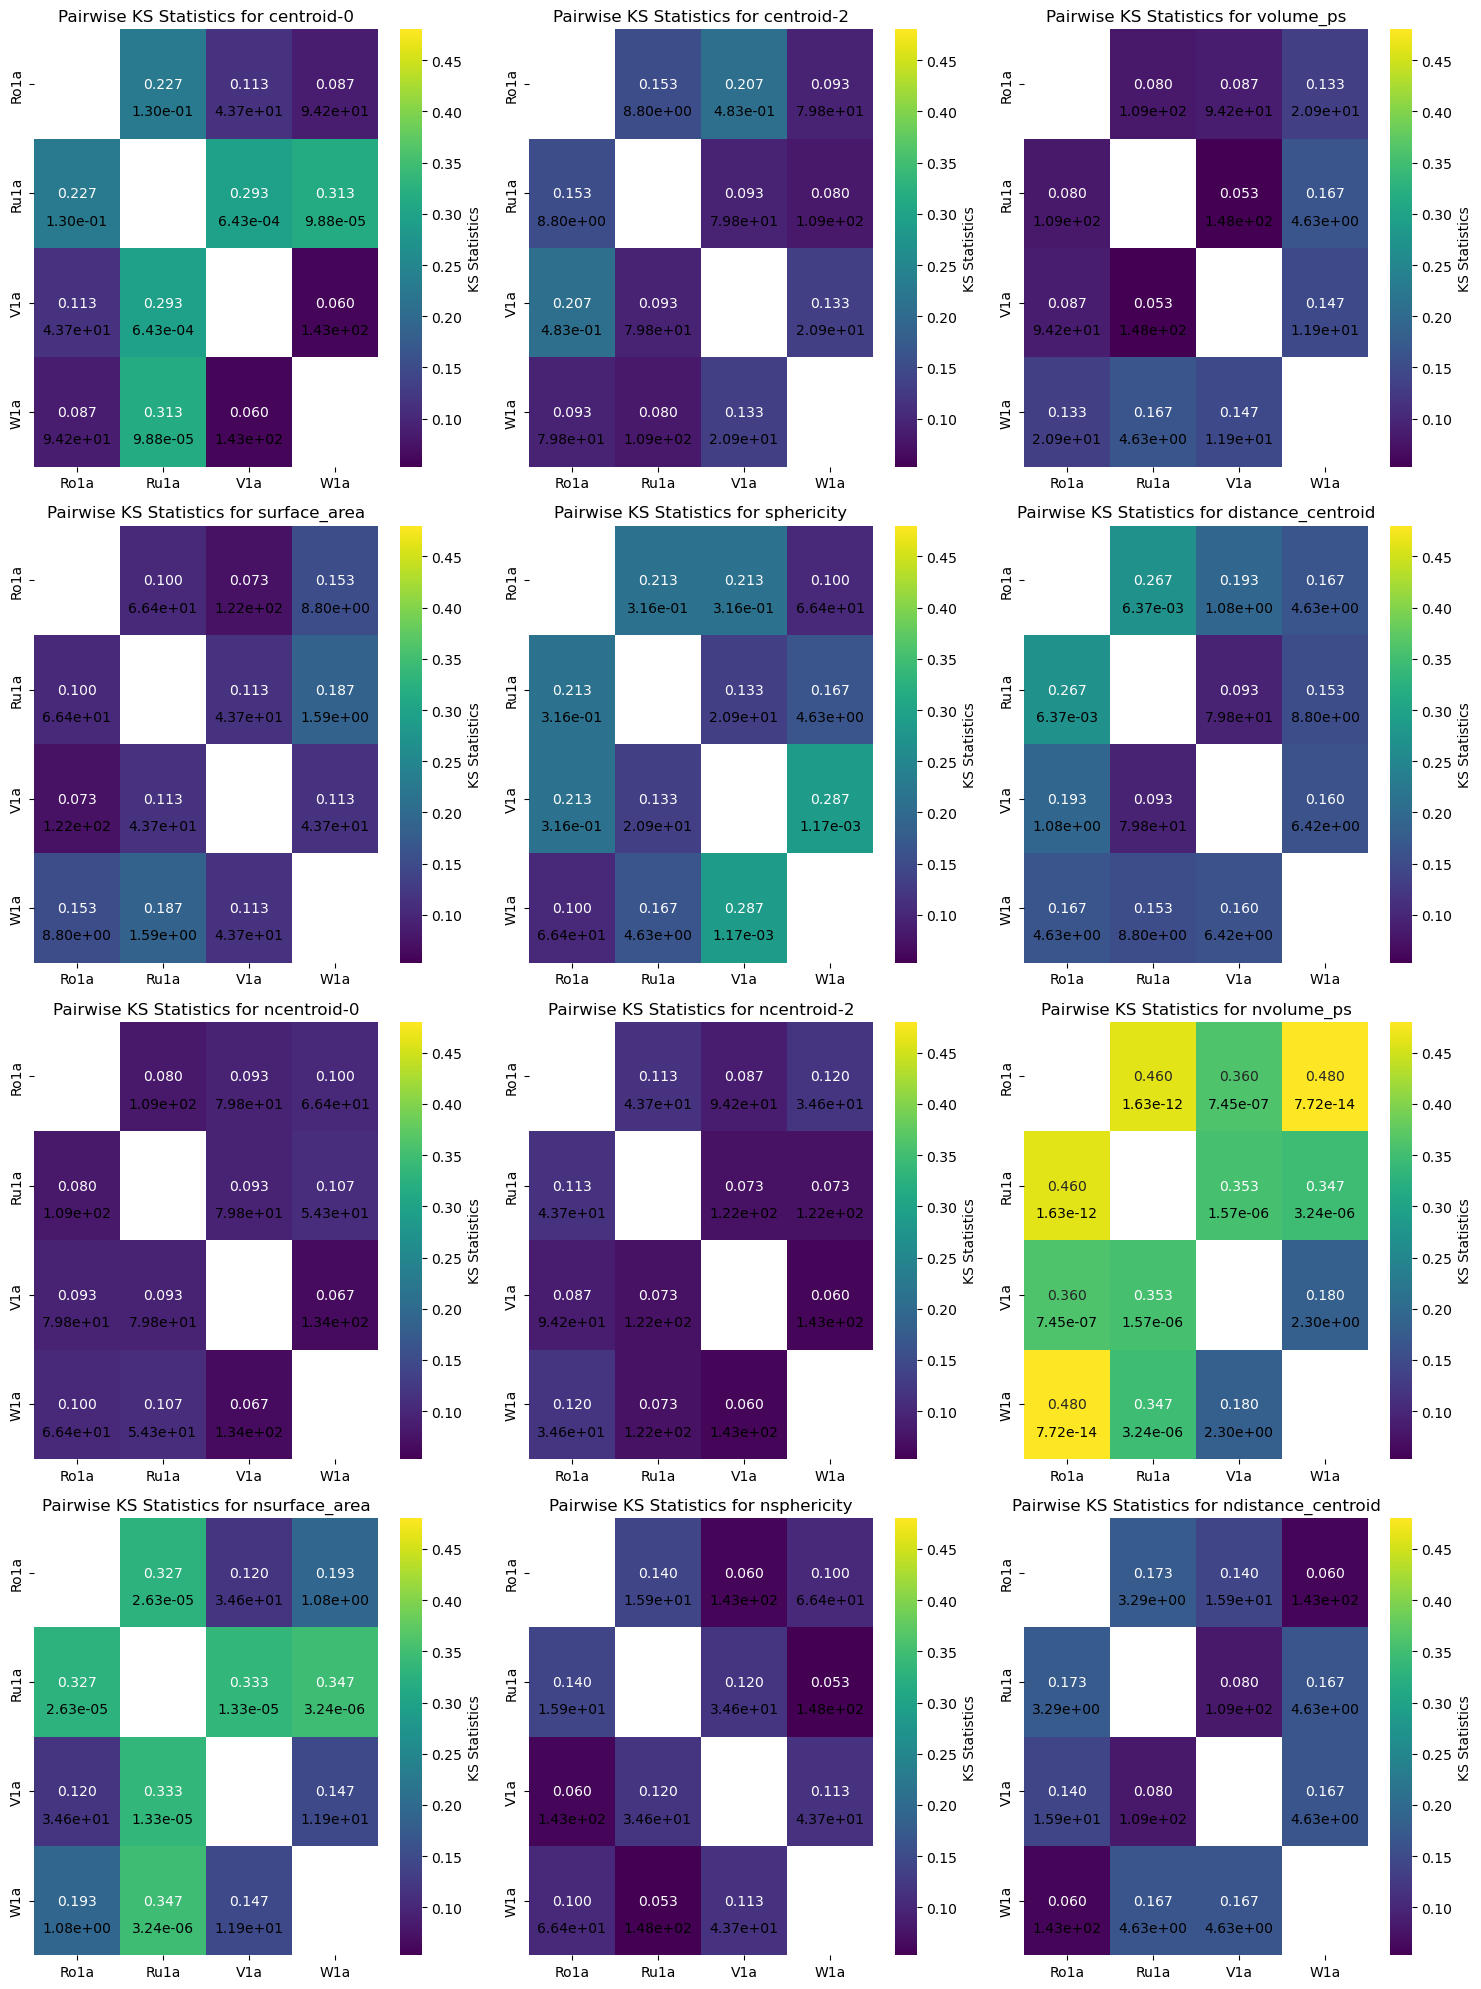

In [50]:
# Plot in heatmaps - Pairwise KS test
# p-value printed after Bonferonni correction (not exactly)
fig, axes = plt.subplots(4, 3, figsize=(15,20))
axes = axes.flatten()
vmin, vmax = min(min(ks) for ks in ks_stats_list), max(max(ks) for ks in ks_stats_list)

# Plot each metric's heatmap
for ax, (df_ks, df_p), metric_name in zip(axes, df_ks_p, metrics_to_compare):
    sns.heatmap(df_ks, annot=True, fmt=".3f", cmap="viridis", ax=ax, vmin=vmin, vmax=vmax, cbar_kws={'label': 'KS Statistics'})
    for i in range(len(df_p)):
        for j in range(len(df_p.columns)):
            if i != j:  # Skip the diagonal
                ax.text(j + 0.5, i + 0.75, f'{(df_p.iloc[i, j]*sampling_size):.2e}', ha='center', va='center', color='black')
    ax.set_title(f"Pairwise KS Statistics for {metric_name}")

# Adjust layout
plt.tight_layout()
plt.show()

In [51]:
# Pairwise Wilcoxon test to see if the related samples (seemingly) share the median (symmetric about 0)
run_pairwise_wilcoxon_test = getattr(pores_pore_metric_test, "run_pairwise_wilcoxon_test")

metrics_to_compare = ['centroid-0', 'centroid-2', 'volume_ps', 'surface_area', 'sphericity', 'distance_centroid', 'ncentroid-0', 'ncentroid-2', 'nvolume_ps', 'nsurface_area', 'nsphericity', 'ndistance_centroid']
sampling_size = 150
normalize = True # Normalize by square root of sample size
check = False

df_wc_p, wc_stats_list, wc_p_values_list = run_pairwise_wilcoxon_test(bread_metrics_dict_centroid_large, metrics_to_compare, bread_types, sampling_size, normalize)

if check:
    for i, (df_wc, df_p) in enumerate(df_wc_p):
        print(f"{metrics_to_compare[i]} KS Statistics:")
        print(df_wc)
        print(f"{metrics_to_compare[i]} P-values:")
        print(df_p)

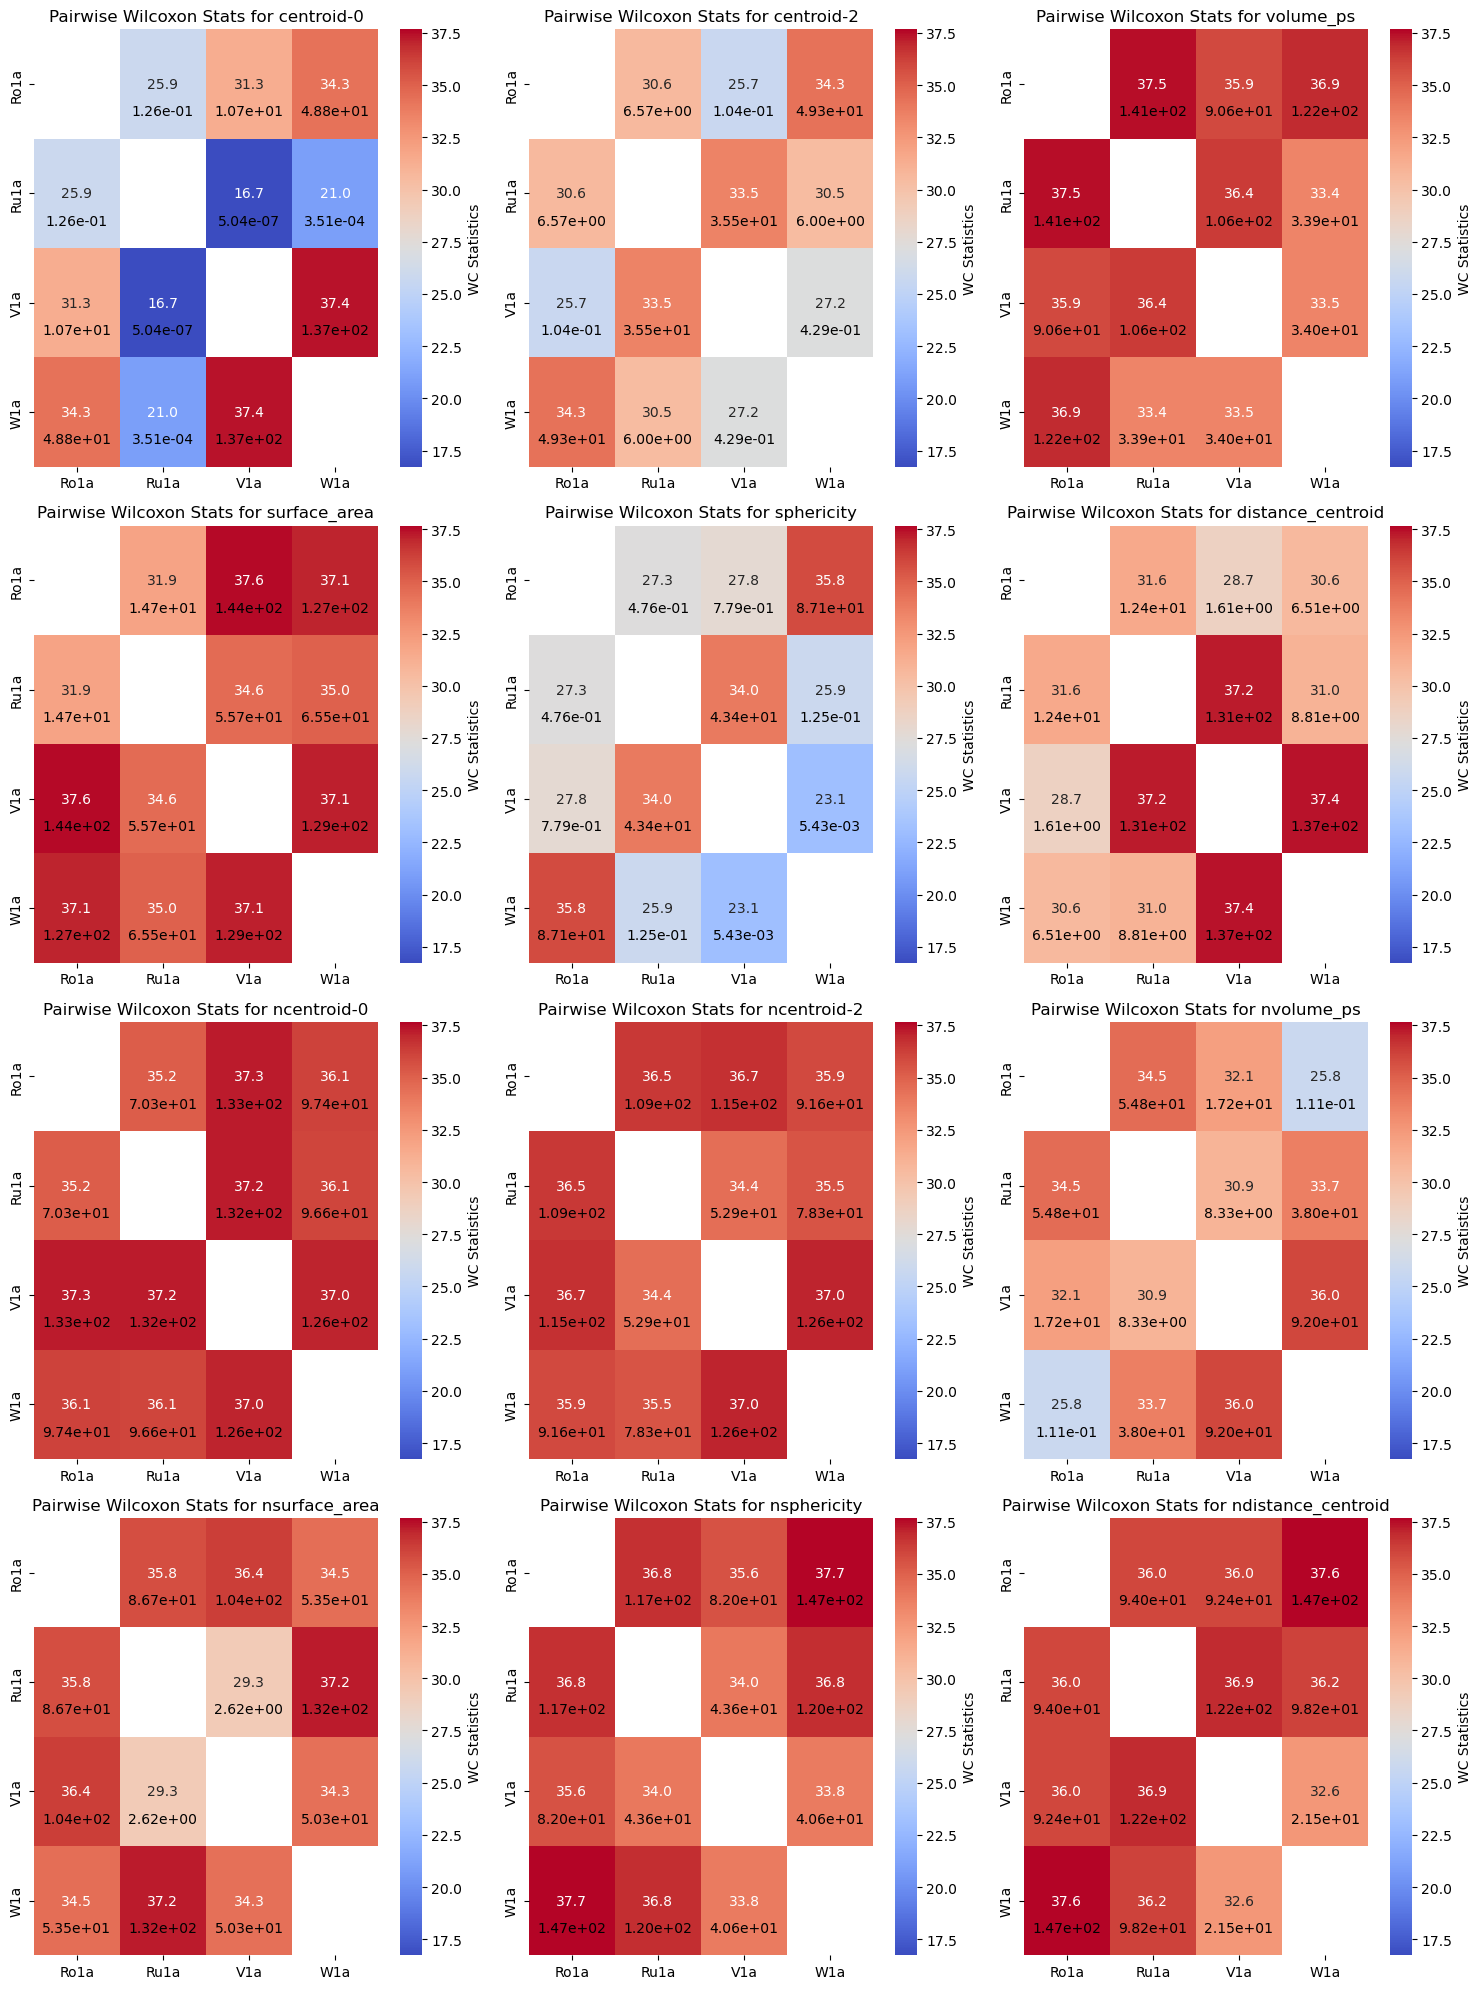

In [52]:
# Plot in heatmaps - Pairwise Wilcoxon test
# p-value printed after Bonferonni correction (not exactly)
fig, axes = plt.subplots(4, 3, figsize=(15,20))
axes = axes.flatten()
vmin, vmax = min(min(ks) for ks in wc_stats_list), max(max(ks) for ks in wc_stats_list)

# Plot each metric's heatmap
for ax, (df_wc, df_p), metric_name in zip(axes, df_wc_p, metrics_to_compare):
    sns.heatmap(df_wc, annot=True, fmt=".1f", cmap="coolwarm", ax=ax, vmin=vmin, vmax=vmax, cbar_kws={'label': 'WC Statistics'})
    for i in range(len(df_p)):
        for j in range(len(df_p.columns)):
            if i != j:  # Skip the diagonal
                ax.text(j + 0.5, i + 0.75, f'{(df_p.iloc[i, j]*sampling_size):.2e}', ha='center', va='center', color='black')
    ax.set_title(f"Pairwise Wilcoxon Stats for {metric_name}")

# Adjust layout
plt.tight_layout()
plt.show()

In [58]:
metrics_to_compare = ['centroid-0', 'centroid-2', 'volume_ps', 'surface_area', 'sphericity', 'distance_centroid', 'ncentroid-0', 'ncentroid-2', 'nvolume_ps', 'nsurface_area', 'nsphericity', 'ndistance_centroid']
sampling_size = 3000

levene_stats_list = []
levene_p_values_list = []

for m,metric in enumerate(metrics_to_compare):
    levene_stat, p_value = levene(bread_metrics_dict["Ro1a"][metric].sample(sampling_size),bread_metrics_dict["Ru1a"][metric].sample(sampling_size),bread_metrics_dict["V1a"][metric].sample(sampling_size),bread_metrics_dict["W1a"][metric].sample(sampling_size))
    levene_stats_list.append(levene_stat)
    levene_p_values_list.append(p_value)
    print(f'Levene Stat for Metric {metric} = {levene_stat}; p-value={p_value*sampling_size}')

Levene Stat for Metric centroid-0 = 42.35232266247874; p-value=9.709480233004844e-24
Levene Stat for Metric centroid-2 = 29.012839023247754; p-value=3.3139242724512173e-15
Levene Stat for Metric volume_ps = 3.254358443434913; p-value=62.17495093584872
Levene Stat for Metric surface_area = 3.6093165864328545; p-value=38.15845770408394
Levene Stat for Metric sphericity = 47.70109645138419; p-value=3.687598056290151e-27
Levene Stat for Metric distance_centroid = 298.99150930576565; p-value=1.0067727406582778e-183
Levene Stat for Metric ncentroid-0 = 5.310606956100992; p-value=3.5296787073625535
Levene Stat for Metric ncentroid-2 = 1.266293641901529; p-value=852.2036638188662
Levene Stat for Metric nvolume_ps = 2.1811409921332388; p-value=264.0725577037005
Levene Stat for Metric nsurface_area = 1.373247917356516; p-value=746.6285561805945
Levene Stat for Metric nsphericity = 14.221850218889255; p-value=9.014214176761784e-06
Levene Stat for Metric ndistance_centroid = 1.452269714857179; p-v

In [59]:
metrics_to_compare = ['centroid-0', 'centroid-2', 'volume_ps', 'surface_area', 'sphericity', 'distance_centroid', 'ncentroid-0', 'ncentroid-2', 'nvolume_ps', 'nsurface_area', 'nsphericity', 'ndistance_centroid']
sampling_size = 3000

fried_stats_list = []
fried_p_values_list = []

for m,metric in enumerate(metrics_to_compare):
    fried_stat, p_value = friedmanchisquare(bread_metrics_dict["Ro1a"][metric].sample(sampling_size),bread_metrics_dict["Ru1a"][metric].sample(sampling_size),bread_metrics_dict["V1a"][metric].sample(sampling_size),bread_metrics_dict["W1a"][metric].sample(sampling_size))
    fried_stats_list.append(fried_stat)
    fried_p_values_list.append(p_value)
    print(f'Fried Stat for Metric {metric} = {fried_stat}; p-value={p_value*sampling_size}')

Fried Stat for Metric centroid-0 = 330.15320000000065; p-value=8.868948002369867e-68
Fried Stat for Metric centroid-2 = 293.63880000000063; p-value=7.105330886481717e-60
Fried Stat for Metric volume_ps = 78.36759407526303; p-value=2.0618740278652888e-13
Fried Stat for Metric surface_area = 157.74920000000566; p-value=1.6825528467940057e-30
Fried Stat for Metric sphericity = 14.565999999998894; p-value=6.683186126991419
Fried Stat for Metric distance_centroid = 254.18040000000474; p-value=2.4477012997424078e-51
Fried Stat for Metric ncentroid-0 = 6.507600000004459; p-value=268.08978049174215
Fried Stat for Metric ncentroid-2 = 0.763200000001234; p-value=2574.7419358915354
Fried Stat for Metric nvolume_ps = 2312.6059999999998; p-value=0.0
Fried Stat for Metric nsurface_area = 226.83039999999892; p-value=2.0101040590455475e-45
Fried Stat for Metric nsphericity = 1.1848000000027241; p-value=2269.956481250892
Fried Stat for Metric ndistance_centroid = 13.691600000005565; p-value=10.06937910

In [ ]:
# # Perform Friedman test for each metric with samples taken three at a time
# test_results = []
# combinations_list = []
# used_combinations = set()

# # Iterate over each metric in the first DataFrame to determine the number of metrics
# num_metrics = len(next(iter(bread_metrics_dict.values())).columns)

# # Iterate over each metric
# for metric_index, metric in enumerate(metrics_to_compare):
#     metric_results = []
    
#     # Iterate over each combination of three samples
#     for sample_combination in itertools.combinations(bread_metrics_dict.keys(), 3):
        
#         sample_combination_set = frozenset(sample_combination)
        
#         if sample_combination_set not in used_combinations:
#             # Extract metric data for the current metric and sample combination
#             sample_metrics = [(bread_metrics_dict[sample][metric].sample(300)).values for sample in sample_combination]

#             # Perform Friedman test for the current metric and sample combination
#             test_statistic, p_value = friedmanchisquare(*sample_metrics)

#             # Store the test statistic and p-value
#             metric_results.append((test_statistic, p_value))
#             combinations_list.append(sample_combination)
#             used_combinations.add(sample_combination_set)
    
#     # Store the results for the current metric
#     test_results.append(metric_results)

# for i, combination in enumerate(combinations_list):
#     print(f'Combination {i + 1}: {combination}')
    
# # Plot summary scatter plot
# fig, ax = plt.subplots(figsize=(5,5))

# for metric_index, metric_results in enumerate(test_results):
#     test_statistics, p_values = zip(*metric_results)
#     sig_markers = ['.' if p < 0.05 else '^' for p in p_values]  # Highlight significant results
    
#     ax.scatter(test_statistics, p_values, label=f'Metric {metric_index + 1}', marker='.', c='skyblue', alpha=0.7)
#     for p in p_values:
#         if p < 0.05:
#             ax.scatter(test_statistics, p_values, marker='.', c='red')  # Highlight significant results
#         else:
#             ax.scatter(test_statistics, p_values, marker='^', c='red')
#     # Add labels or annotations to data points
#     for i, (test_statistic, p_value) in enumerate(zip(test_statistics, p_values)):
#         ax.annotate(f'{i+1}', (test_statistic, p_value), textcoords="offset points", xytext=(0,5), ha='center')

# ax.set_title('Friedman Test Results')
# ax.set_xlabel('Test Statistic')
# ax.set_ylabel('p-value')
# ax.axhline(y=0.05, color='gray', linestyle='--', label='Significance Threshold (0.05)')
# ax.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()

In [ ]:
# Can I run ANOVA? - check (not normally distributed)